In [ ]:
import urllib.request, urllib.error, urllib.parse
from bs4 import BeautifulSoup

Now, individual article content needs scraping. The below listing uses `BeautifulSoup` and the `requests` library to scrape the contents of a given url, which was sourced from the sitemap. The `lxml` parser was chosen again for its speed, and since the necessary external C dependency had already been installed with the `lxml-xml` parser during the XML sitemap scraping, no additional setup was needed. 

Richardson, L. (2004–2025). Beautiful Soup Documentation. Retrieved April 27, 2025, from https://www.crummy.com/software/BeautifulSoup/bs4/doc/#installing-a-parser 

In [ ]:

def extract_html_from_url(url):
    """given a url, return a soup object which contains the html content of the page"""
    request = urllib.request.Request(url, headers={'User-Agent': 'Mozilla/5.0'})
    html_content = urllib.request.urlopen(request).read().decode('utf-8')
    soup = BeautifulSoup(html_content, 'lxml')
    return soup


The contents of the HTML were analysed and parsed into a dictionary capturing the title, author, date, sector, stock codes, and the article body, as demonstrated in the below listing, utilising Beautiful Soup to extract data from the relevant tags. Below is an example output from the parsing process:
```{python}
soup_test = extract_html_from_url('https://smallcaps.com.au/galan-lithium-directors-show-confidence-share-purchase/')
parsed_dict = parse_html_to_dict(soup_test)
parsed_dict

{'title': 'Galan Lithium directors show confidence with $1.4 million share purchase',
 'author': 'Colin Hay',
 'date_string': 'May 23, 2024',
 'sector': 'Mining',
 'stock_codes': ['ASX:GLN'],
 'document': 'Galan Lithium (ASX: GLN) managing director Juan Pablo....}
```

In [ ]:
def parse_html_to_dict(soup_obj):    
    """
    Parse the HTML content of a Small Caps article into a dictionary, extracting the title, author, date, sector, stock codes, and document.
    """

    # Parse the title from the <h1> element; fall back to <title> if not found.
    title_tag = soup_obj.find("h1", class_="c-post-header__title")
    if title_tag:
        title = title_tag.get_text(strip=True)
    else:
        title = soup_obj.title.get_text(strip=True) if soup_obj.title else None

    # parse the author from the header
    author_tag = soup_obj.find('a', class_='c-post-header__author-link')
    author = author_tag.get_text(strip=True) if author_tag else None

    # parse the date from the first <time> tag
    date_tag = soup_obj.find('time')
    date_string = date_tag.get_text(strip=True) if date_tag else None

    # parse the sector from the navigation
    sector = None
    nav_section = soup_obj.find("div", class_="c-post__navigation")
    if nav_section:
        sector_tag = nav_section.find("a", class_="c-post__navigation-link")
        sector = sector_tag.get_text(strip=True) if sector_tag else None

    # parse the stock codes
    stock_codes = []
    # look for any div whose class attribute contains "c-tags"
    tags_container = soup_obj.find(
        lambda tag: tag.name == "div" and tag.get("class") and any("c-tags" in c for c in tag.get("class"))
    )
    if tags_container:
        stock_text_span = tags_container.find("span", class_="c-tags__text")
        if stock_text_span and "Stock Codes" in stock_text_span.get_text():
            # Try to find an inner container if available
            inner = tags_container.find("div", class_="c-tags__inner")
            if inner:
                stock_codes = [a.get_text(strip=True) for a in inner.find_all("a", class_="c-tags__item c-tags__item--link")]
            else:
                stock_codes = [a.get_text(strip=True) for a in tags_container.find_all("a", class_="c-tags__item c-tags__item--link")]

    # parse the article body
    body_tag = soup_obj.find("div", class_="c-rich-text c-post__rich-text")
    if body_tag:
        # Use "\n" as separator to preserve paragraph breaks
        document = body_tag.get_text(separator = " ", strip=True)
    else:
        document = None

    return {
        'title': title,
        'author': author,
        'date_string': date_string,
        'sector': sector,
        'stock_codes': stock_codes,
        'document': document
    }

In [4]:
# import article_metadata.csv as a pandas dataframe
import pandas as pd
from time import sleep
import time

# Initialize an empty DataFrame to store the articles
crawl_throttle_time_s = 3 

# Read the metadata CSV file
df = pd.read_csv('article_metadata.csv')
article_df = pd.read_csv('scraped_articles.csv')

for index, row in df.iloc[1210:1500].iterrows():
    print(f"Processing {index}...")
    url = row['url']

    # Start a timer
    start_time = time.time()
    try:
        # Extract and parse the HTML content
        soup = extract_html_from_url(url)
        parsed = parse_html_to_dict(soup)
        article_df = pd.concat([article_df, pd.DataFrame([parsed])], ignore_index=True)
        article_df.to_csv('scraped_articles.csv', index=False)
    except Exception as e: 
        print(f"Error processing {url} at index {index}: {e}")
    
    # Calculate the elapsed time and throttle if necessary
    elapsed_time = time.time() - start_time
    if elapsed_time < crawl_throttle_time_s:
        sleep(crawl_throttle_time_s - elapsed_time)


Processing 1210...
Processing 1211...
Processing 1212...
Processing 1213...
Processing 1214...
Processing 1215...
Processing 1216...
Processing 1217...
Processing 1218...
Processing 1219...
Processing 1220...
Processing 1221...
Processing 1222...
Processing 1223...
Processing 1224...
Processing 1225...
Processing 1226...
Processing 1227...
Processing 1228...
Processing 1229...
Processing 1230...
Processing 1231...
Processing 1232...
Processing 1233...
Processing 1234...
Processing 1235...
Processing 1236...
Processing 1237...
Processing 1238...
Processing 1239...
Processing 1240...
Processing 1241...
Processing 1242...
Processing 1243...
Processing 1244...
Processing 1245...
Processing 1246...
Processing 1247...
Processing 1248...
Processing 1249...
Processing 1250...
Processing 1251...
Processing 1252...
Processing 1253...
Processing 1254...
Processing 1255...
Processing 1256...
Processing 1257...
Processing 1258...
Processing 1259...
Processing 1260...
Processing 1261...
Processing 1

In [6]:
article_df

,title,author,date_string,sector,stock_codes,document
0,Surprise Budget will show longer term deficits,John Beveridge,"March 23, 2025",Hot Topics,[],This week’s Federal Budget should be the econo...
1,Weekly wrap: supermarket stocks boost market’s...,John Beveridge,"March 22, 2025",Hot Topics,[],It’s official – supermarket prices are rising ...
2,DRC suspension of exports expected to result i...,Colin Hay,"March 21, 2025",Hot Topics,[],Reports that the Democratic Republic of the Co...
3,GreenHy2 secures H2Core deal to advance superc...,Colin Hay,"March 21, 2025",Energy,['ASX:H2G'],Solid state hydrogen storage developer GreenHy...
4,Compumedics reaches $20m in Chinese MEG sales ...,Colin Hay,"March 21, 2025",Biotech,['ASX:CMP'],Brain research technologies specialist Compume...
...,...,...,...,...,...,...
1495,World’s largest untapped iron ore project secu...,Colin Hay,"April 15, 2024",Mining,[ASX:RIO],Reports out of the West African nation of Guin...
1496,Adherium’s Hailie Smartinhaler receives FDA ap...,Imelda Cotton,"April 15, 2024",Technology,[ASX:ADR],Medical device developer Adherium (ASX: ADR) h...
1497,Kin Mining merges with PNX Metals to target ex...,Imelda Cotton,"April 15, 2024",Mining,"[ASX:KIN, ASX:PNX]",Kin Mining (ASX: KIN) has proposed a $123 mill...
1498,Aurumin completes first-pass drilling campaign...,Imelda Cotton,"April 15, 2024",Mining,[ASX:AUN],Aurumin (ASX: AUN) has completed a first-pass ...


In [7]:
article_df
sample_data_df = article_df
sample_data_df = sample_data_df.dropna(subset=['document']).reset_index(drop=True)
sample_data_df

,title,author,date_string,sector,stock_codes,document
0,Surprise Budget will show longer term deficits,John Beveridge,"March 23, 2025",Hot Topics,[],This week’s Federal Budget should be the econo...
1,Weekly wrap: supermarket stocks boost market’s...,John Beveridge,"March 22, 2025",Hot Topics,[],It’s official – supermarket prices are rising ...
2,DRC suspension of exports expected to result i...,Colin Hay,"March 21, 2025",Hot Topics,[],Reports that the Democratic Republic of the Co...
3,GreenHy2 secures H2Core deal to advance superc...,Colin Hay,"March 21, 2025",Energy,['ASX:H2G'],Solid state hydrogen storage developer GreenHy...
4,Compumedics reaches $20m in Chinese MEG sales ...,Colin Hay,"March 21, 2025",Biotech,['ASX:CMP'],Brain research technologies specialist Compume...
...,...,...,...,...,...,...
1487,World’s largest untapped iron ore project secu...,Colin Hay,"April 15, 2024",Mining,[ASX:RIO],Reports out of the West African nation of Guin...
1488,Adherium’s Hailie Smartinhaler receives FDA ap...,Imelda Cotton,"April 15, 2024",Technology,[ASX:ADR],Medical device developer Adherium (ASX: ADR) h...
1489,Kin Mining merges with PNX Metals to target ex...,Imelda Cotton,"April 15, 2024",Mining,"[ASX:KIN, ASX:PNX]",Kin Mining (ASX: KIN) has proposed a $123 mill...
1490,Aurumin completes first-pass drilling campaign...,Imelda Cotton,"April 15, 2024",Mining,[ASX:AUN],Aurumin (ASX: AUN) has completed a first-pass ...


# Article EDA

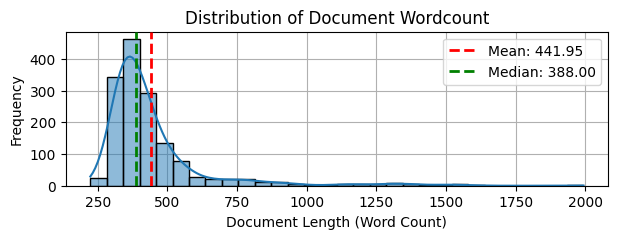

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate document lengths
sample_data_df['document_length'] = sample_data_df['document'].apply(lambda x: len(x.split()))
# Plot histogram with KDE
plt.figure(figsize=(7, 2))
sns.histplot(sample_data_df['document_length'], bins=30, kde=True, stat="count", zorder=2)

# Add vertical mean line
mean_length = sample_data_df['document_length'].mean()
plt.axvline(mean_length, color='r', linestyle='dashed', linewidth=2, label=f'Mean: {mean_length:.2f}', zorder=3)
# add median verticle line
median_length = sample_data_df['document_length'].median()
plt.axvline(median_length, color='g', linestyle='dashed', linewidth=2, label=f'Median: {median_length:.2f}', zorder=3)

# Customize plot
plt.title('Distribution of Document Wordcount')
plt.xlabel('Document Length (Word Count)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, zorder=1)
plt.show()


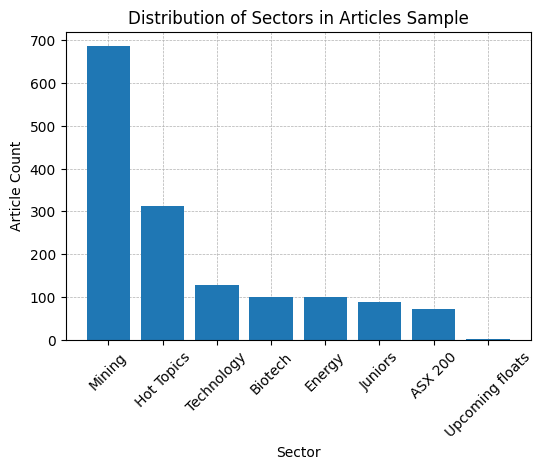

In [9]:
# make a barplot of the distribution of sectors
plt.figure(figsize=(6, 4))
sector_counts = sample_data_df['sector'].value_counts()
plt.bar(sector_counts.index, sector_counts.values, zorder=2)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, zorder=1)
plt.title('Distribution of Sectors in Articles Sample')
plt.xlabel('Sector')
plt.ylabel('Article Count')
plt.xticks(rotation=45)
plt.show()


C:\Users\hkrug\AppData\Local\Temp\ipykernel_18268\778579574.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=stock_code_counts.index, y=stock_code_counts.values, palette=[sector_color_map[sector] for sector in stock_code_sectors], zorder=2)


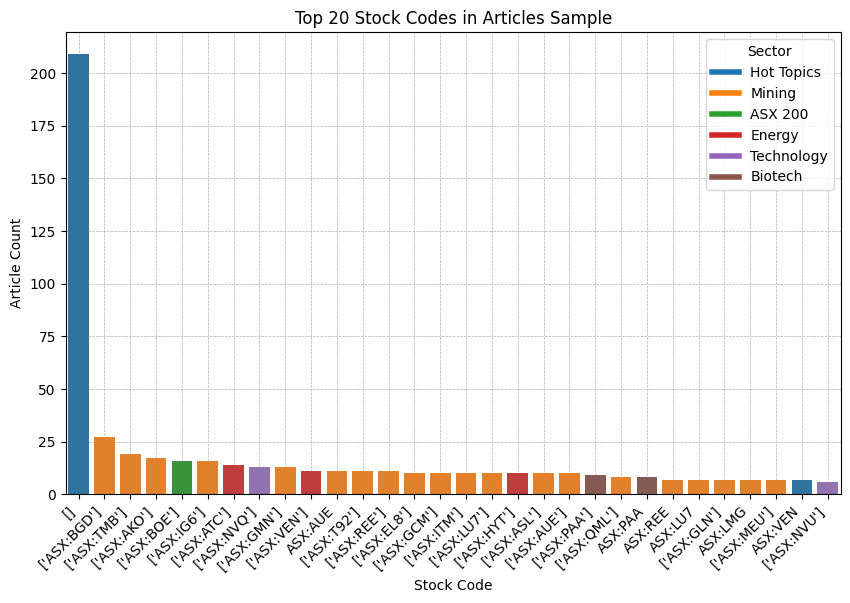

In [10]:
# Flatten the list of stock codes
stock_codes = sample_data_df['stock_codes'].explode()
# Count the occurrences of each stock code
stock_code_counts = stock_codes.value_counts().head(30)

# Create a mapping of stock codes to sectors
stock_to_sector = sample_data_df[['stock_codes', 'sector']].dropna().explode('stock_codes').drop_duplicates(subset=['stock_codes']).set_index('stock_codes')['sector']

# Map the stock codes to their respective sectors
stock_code_sectors = stock_code_counts.index.map(stock_to_sector)

# Create a color palette for the sectors
unique_sectors = stock_code_sectors.unique()
colors = sns.color_palette('tab10', len(unique_sectors))
sector_color_map = dict(zip(unique_sectors, colors))

# Plot the distribution
plt.figure(figsize=(10, 6))
bars = sns.barplot(x=stock_code_counts.index, y=stock_code_counts.values, palette=[sector_color_map[sector] for sector in stock_code_sectors], zorder=2)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, zorder=1)
plt.title('Top 20 Stock Codes in Articles Sample')
plt.xlabel('Stock Code')
plt.ylabel('Article Count')
plt.xticks(rotation=45, ha='right')

# Create a legend
handles = [plt.Line2D([0], [0], color=sector_color_map[sector], lw=4) for sector in unique_sectors]
plt.legend(handles, unique_sectors, title='Sector', loc='best')

plt.show()


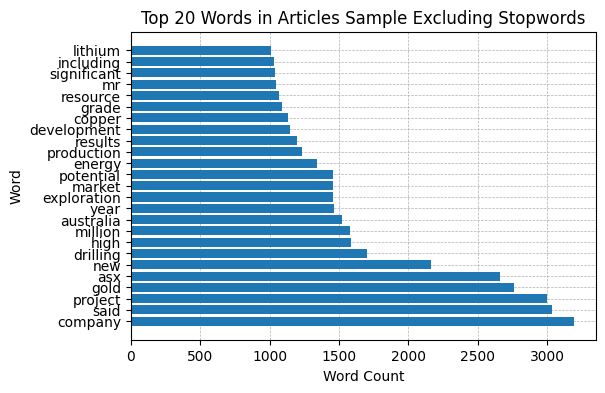

In [11]:
# make a barplot of the top 20 words in the document excluding stopwords, using sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text
from sklearn.pipeline import make_pipeline

# tokenize the document excluding stopwords
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(sample_data_df['document'])
words = vectorizer.get_feature_names_out()
word_counts = X.toarray().sum(axis=0)
word_counts_df = pd.DataFrame({'word': words, 'count': word_counts})
top_words_df = word_counts_df.nlargest(25, 'count')

# plot the top 20 words
plt.figure(figsize=(6, 4))
plt.barh(top_words_df['word'], top_words_df['count'], zorder=2)
plt.grid(True, which='both', linestyle='--', linewidth=0.5, zorder=1)
plt.title('Top 20 Words in Articles Sample Excluding Stopwords')
plt.xlabel('Word Count')
plt.ylabel('Word')
plt.show()


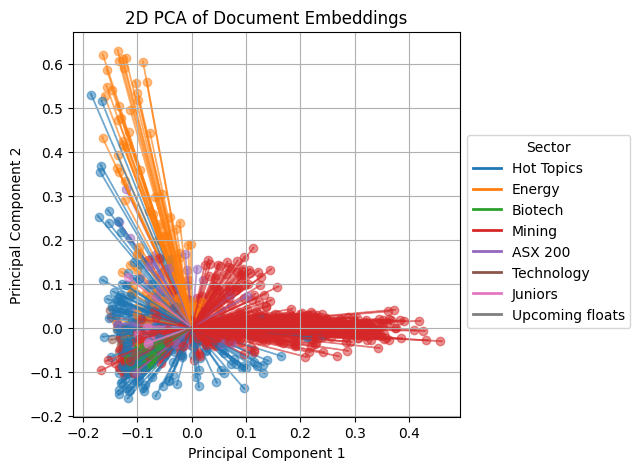

In [12]:
# make a 2d biplot of the documents using principal component analysis
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english')
tokenized_documents = vectorizer.fit_transform(sample_data_df['document'])
principle_components = PCA(n_components=2).fit_transform(tokenized_documents.toarray())  # Fit the PCA to the TF-IDF matrix
pca_df = pd.DataFrame(principle_components, columns=['PC1', 'PC2'])
plt.figure(figsize=(5, 5))

sectors = sample_data_df['sector'].unique()
colors = sns.color_palette('tab10', len(sectors))
sector_color_map = dict(zip(sectors, colors))

for i in range(len(pca_df)):
    sector = sample_data_df['sector'][i]
    color = sector_color_map.get(sector, 'black')  # Use 'black' as default color if sector is not found
    plt.arrow(0, 0, pca_df['PC1'][i], pca_df['PC2'][i], color=color, alpha=0.5)
    plt.scatter(pca_df['PC1'][i], pca_df['PC2'][i], color=color, alpha=0.5)

handles = [plt.Line2D([0], [0], color=color, lw=2) for color in colors]
labels = sectors
plt.legend(handles, labels, title='Sector', loc='upper left', bbox_to_anchor=(1, 0.75))
plt.title('2D PCA of Document Embeddings')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()
